Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Search and ranking

Information on the Python Packages used:  

http://docs.python.org/library/sqlite3.html  
http://www.crummy.com/software/BeautifulSoup/  
http://docs.python.org/library/urlparse.html  
http://docs.python.org/library/re.html  
http://nltk.org/  

In [1]:
import os
import urllib2
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.sql as psql
from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display
from bs4 import BeautifulSoup
from urlparse import urljoin
from sqlite3 import dbapi2 as sqlite

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)

Specifying the path to the files

In [2]:
outputs = "/home/rsouza/Dropbox/Renato/ModMinDados/outputs/"

dbfile = u"searchindex.sqlite"
db = os.path.join(outputs,dbfile)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt

#### First block of classes and functions: crawling

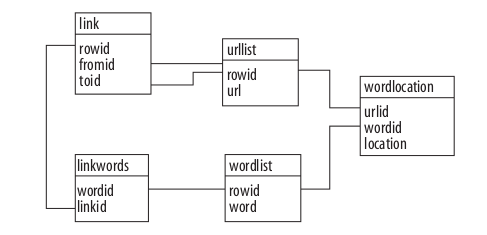

In [3]:
Image(filename='../templates/db_schema.png')

In [4]:
class crawler:
    def __init__(self,dbname):
        self.con=sqlite.connect(dbname)
        
    def __del__(self):
        self.con.close()

    def dbcommit(self):
        self.con.commit()

    def createindextables(self):
        self.con.execute(u'create table if not exists urllist(url)')
        self.con.execute(u'create table if not exists wordlist(word)')
        self.con.execute(u'create table if not exists wordlocation(urlid,wordid,location)')
        self.con.execute(u'create table if not exists link(fromid integer,toid integer)')
        self.con.execute(u'create table if not exists linkwords(wordid,linkid)')
        self.con.execute(u'create index if not exists wordidx on wordlist(word)')
        self.con.execute(u'create index if not exists urlidx on urllist(url)')
        self.con.execute(u'create index if not exists wordurlidx on wordlocation(wordid)')
        self.con.execute(u'create index if not exists urltoidx on link(toid)')
        self.con.execute(u'create index if not exists urlfromidx on link(fromid)')
        self.dbcommit()

    def isindexed(self,url):
        '''Verify whether url is already indexed'''
        q = u"select rowid from urllist where url='{}'"
        u = self.con.execute(q.format(url)).fetchone()
        if u != None:
            q = u"select * from wordlocation where urlid={}"
            v = self.con.execute(q.format(u[0])).fetchone()
            if v != None:
                return True
        return False        

    def gettextonly(self,soup):
        '''Extract raw text from html page'''
        v = soup.string
        if v == None:   
            c = soup.contents
            resulttext = ''
            for t in c:
                subtext = self.gettextonly(t)
                resulttext += subtext+'\n'
            return resulttext
        else:
            return v.strip()

    def separatewords(self,text):
        '''splits the sentences by the non alpha characters
        and converts all words to lowercase'''
        splitter = re.compile('\\W*', flags=re.U)
        return [s.lower() for s in splitter.split(text) if s != '']

    def getentryid(self, table, field, value, createnew=True):
        '''Add page id to the database, if not present'''
        q = u"select rowid from {} where {}='{}'"
        cursor = self.con.execute(q.format(table,field,value))
        result = cursor.fetchone()
        if result == None:
            q = u"insert into {} ({}) values ('{}')"
            cursor = self.con.execute(q.format(table,field,value))
            return cursor.lastrowid
        else:
            return result[0]     

    def addtoindex(self,url,sopa):
        '''Add url to the index if not there'''
        if self.isindexed(url): 
            print(u'Page {} already indexed...'.format(url))
            return
        print(u'Indexing: {}'.format(url))
        text = self.gettextonly(sopa)
        words = self.separatewords(text)
        urlid = self.getentryid('urllist', 'url', url)
        for i in range(len(words)):
            word = words[i]
            if word in ignorewords: 
                continue
            wordid = self.getentryid('wordlist','word',word)
            q = u"insert into wordlocation (urlid,wordid,location) values ({},{},{})"
            self.con.execute(q.format(urlid,wordid,i))
        
    def addlinkref(self,urlFrom,urlTo,linkText):
        '''Add a link between two pages'''
        words = self.separatewords(linkText)
        fromid = self.getentryid(u'urllist',u'url', urlFrom)
        toid = self.getentryid(u'urllist',u'url', urlTo)
        if fromid == toid:
            return
        q = u"insert into link(fromid,toid) values ({},{})"
        cursor = self.con.execute(q.format(fromid,toid))
        linkid = cursor.lastrowid
        for word in words:
            if word in ignorewords: 
                continue
            wordid = self.getentryid(u'wordlist',u'word', word)
            q = u"insert into linkwords(linkid,wordid) values ({},{})"
            self.con.execute(q.format(linkid,wordid))
    
    def crawl(self,pages,depth=1):
        '''Starts indexing seed page(s), goes indexing all pages following
        breadth first, until the desired depth'''
        print(u'Seed URL(s)')        
        for p in pages: print(p)
        print(u'\nIndexing from seed with depth of {}\n'.format(depth))
        for i in range(depth+1):
            newpages = {}
            for page in pages:
                try:
                    c = urllib2.urlopen(page)
                except:
                    print(u'Could not access page: {}'.format(page))
                    continue
                try:
                    p = c.read()
                    soup = BeautifulSoup(p)
                    self.addtoindex(page,soup)
                    links = soup(u'a')
                    for link in links:
                        if (u'href' in dict(link.attrs)):
                            url = urljoin(page,link[u'href'])
                            if url.find(u"'") != -1:
                                continue
                            url = url.split(u'#')[0]  #Keeps base url
                            if url[0:4] == u'http' and not self.isindexed(url):
                                newpages[url] = 1
                            linkText = self.gettextonly(link)
                            self.addlinkref(page,url,linkText)
                    self.dbcommit()
                except:
                    print(u"Could not parse page {}".format(page))
                    raise
            self.dbcommit()
            pages = newpages

    def calculatepagerank(self,iterations=20):
        '''Initialize each url with pagerank = 1, and iterates until
        it reaches the limit. Calculates pagerank with damping factor'''
        self.con.execute(u'drop table if exists pagerank')
        self.dbcommit()
        self.con.execute(u'create table pagerank(urlid primary key,score)')
        for (urlid,) in self.con.execute(u'select rowid from urllist'):
            q = u'insert into pagerank(urlid,score) values ({},1.0)'
            self.con.execute(q.format(urlid))
        self.dbcommit()
        for i in range(iterations):
            print(u"Iteration {}".format(i))
            for (urlid,) in self.con.execute(u'select rowid from urllist'):
                pr = 0.15
                q1 = u'select distinct fromid from link where toid = {}'
                for (linker,) in self.con.execute(q1.format(urlid)):
                    q2 = u'select score from pagerank where urlid = {}'
                    linkingpr = self.con.execute(q2.format(linker)).fetchone()[0]
                    q3 = u'select count(*) from link where fromid = {}'
                    linkingcount = self.con.execute(q3.format(linker)).fetchone()[0]
                    pr += 0.85 * (linkingpr/linkingcount)
                q4 = u'update pagerank set score = {} where urlid = {}'
                self.con.execute(q4.format(pr,urlid))
            self.dbcommit()

#### Second block of classes and functions: searching

In [5]:
class searcher:
    def __init__(self,dbname):
        self.con=sqlite.connect(dbname)

    def __del__(self):
        self.con.close()

    def getmatchrows(self,q):
        fieldlist=u'w0.urlid'
        tablelist=u''  
        clauselist=u''
        wordids=[]
        words=q.split(u' ')  
        tablenumber=0
        for word in words:
            q = u"select rowid from wordlist where word='{}'"
            wordrow = self.con.execute(q.format(word)).fetchone()
            if wordrow != None:
                wordid = wordrow[0]
                wordids.append(wordid)
                if tablenumber > 0:
                    tablelist += u','
                    clauselist += u' and '
                    clauselist += u'w{}.urlid=w{}.urlid and '.format(tablenumber-1,tablenumber)
                fieldlist += u',w{}.location'.format(tablenumber)
                tablelist += u'wordlocation w{}'.format(tablenumber)   
                clauselist += u'w{}.wordid={}'.format(tablenumber,wordid)
                tablenumber += 1
        fullquery = u'select {} from {} where {}'.format(fieldlist,tablelist,clauselist)
        cursor = self.con.execute(fullquery)
        rows = [row for row in cursor]
        return rows, wordids

    def getscoredlist(self,rows,wordids):
        totalscores = dict([(row[0],0) for row in rows])
        weights=[(1.0,self.frequencyscore(rows)),
                 (1.0,self.locationscore(rows)), 
                 (1.0,self.distancescore(rows)),
                 (1.0,self.inboundlinkscore(rows)),
                 #(1.0,self.linktextscore(rows,wordids)),
                 (1.0,self.pagerankscore(rows))]
        for (weight,scores) in weights:
            for url in totalscores:
                totalscores[url] += weight*scores[url]
        return totalscores

    def geturlname(self,id):
        q = u"select url from urllist where rowid = {}"
        return self.con.execute(q.format(id)).fetchone()[0]

    def query(self,q):
        try:
            rows,wordids = self.getmatchrows(q)
        except:
            print(u'No results in the database...')
            return
        scores = self.getscoredlist(rows,wordids)
        rankedscores = [(score,url) for (url,score) in scores.items()]
        rankedscores.sort()
        rankedscores.reverse()
        print(u'\nResultados para busca por {}:'.format(q))
        for (score,urlid) in rankedscores[0:10]:
            print(u'{}\t{}'.format(score, self.geturlname(urlid)))
        return wordids,[r[1] for r in rankedscores[0:10]]

    def normalizescores(self,scores,smallIsBetter=0):
        vsmall=0.00001 # Avoiding division by zero
        if smallIsBetter:
            minscore = min(scores.values())
            return dict([(u,float(minscore)/max(vsmall,l)) for (u,l) in scores.items()])
        else:
            maxscore = max(scores.values())
            if maxscore == 0:
                maxscore = vsmall
            return dict([(u,float(c)/maxscore) for (u,c) in scores.items()])

    def frequencyscore(self,rows):
        counts = dict([(row[0],0) for row in rows])
        for row in rows:
            counts[row[0]] += 1
        return self.normalizescores(counts)

    def locationscore(self,rows):
        locations = dict([(row[0],1000000) for row in rows])
        for row in rows:
            loc = sum(row[1:])
            if loc < locations[row[0]]:
                locations[row[0]] = loc
        return self.normalizescores(locations,smallIsBetter=1)

    def distancescore(self,rows):
        if len(rows[0]) <= 2: 
            return dict([(row[0],1.0) for row in rows])
        mindistance = dict([(row[0],1000000) for row in rows])
        for row in rows:
            dist = sum([abs(row[i]-row[i-1]) for i in range(1,len(row))])
            if dist < mindistance[row[0]]:
                mindistance[row[0]]=dist
        return self.normalizescores(mindistance,smallIsBetter=1)

    def inboundlinkscore(self,rows):
        uniqueurls = dict([(row[0],1) for row in rows])
        q = u'select count(*) from link where toid = {}'
        inboundcount = dict([(u,self.con.execute(q.format(u)).fetchone()[0]) for u in uniqueurls])   
        return self.normalizescores(inboundcount)

    def linktextscore(self,rows,wordids):
        linkscores = dict([(row[0],0) for row in rows])
        for wordid in wordids:
            q = u'select link.fromid,link.toid from linkwords,'
            q += u'link where wordid={} and linkwords.linkid=link.rowid'
            cursor = self.con.execute(q.format(wordid))
            for (fromid,toid) in cursor:
                if toid in linkscores:
                    q = u'select score from pagerank where urlid={}'
                    pr=self.con.execute(q.format(fromid)).fetchone()[0]
                    linkscores[toid] += pr
        maxscore = max(linkscores.values())
        normalizedscores = dict([(u,float(l)/maxscore) for (u,l) in linkscores.items()])
        return normalizedscores

    def pagerankscore(self,rows):
        q = u'select score from pagerank where urlid={}'
        pageranks=dict([(row[0],self.con.execute(q.format(row[0])).fetchone()[0]) for row in rows])
        maxrank = max(pageranks.values())
        normalizedscores = dict([(u,float(l)/maxrank) for (u,l) in pageranks.items()])
        return normalizedscores

Defining seed pages

In [6]:
seed1 = [u'http://www.oglobo.com/']
seed2 = [u'http://emap.fgv.br/']

Instantiating the crawler

In [7]:
crawl = crawler(db)

Creating tables - needed only in the first time

In [8]:
crawl.createindextables()

Crawling to a specific depth level

In [9]:
crawl.crawl(seed1,1)

Seed URL(s)
http://www.oglobo.com/

Indexing from seed with depth of 1

Page http://www.oglobo.com/ already indexed...
Indexing: http://oglobo.globo.com/esportes/anderson-silva/
Indexing: http://oglobo.globo.com/sociedade/tecnologia/site-gera-revolta-nas-redes-sociais-ao-divulgar-cpf-de-cidadaos-sem-seu-consentimento-16062433
Indexing: http://oglobo.globo.com/economia/o-dia-do-trabalho-pelo-mundo-16034950
Indexing: http://oglobo.globo.com/estilo/boa-viagem/cruzeiros/
Indexing: http://oglobo.globo.com/mundo/dezenas-de-civis-morrem-tentando-fugir-de-barco-de-cidade-iemenita-16072899
Indexing: http://oglobo.globo.com/sociedade/ciencia/estamos-chegando-la-mas-por-que-queremos-recriar-um-mamute-16060491
Indexing: http://oglobo.globo.com/sociedade/religiao/catolicos-celebram-kurusu-ara-no-paraguai-16046031
Indexing: http://oglobo.globo.com/mundo/rainha-conhece-princesa-charlotte-que-registrada-por-william-16061318
Indexing: http://oglobo.globo.com/cultura/filmes/astro-de-bollywood-condenado-

Calculates pagerank with n iterations

In [10]:
crawl.calculatepagerank(25)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24


Instantiating the searcher

In [11]:
search = searcher(db)

Querying the index

In [12]:
query = u'matemática'
print(search.query(query))


Resultados para busca por matemática:
4.51864790782	http://oglobo.globo.com/esportes/fluminense/
4.02723900297	http://oglobo.globo.com/esportes/botafogo/
3.70398279118	http://oglobo.globo.com/sociedade/educacao/
3.43729705441	http://oglobo.globo.com/esportes/rmp/
3.39494091084	http://oglobo.globo.com/rio/ancelmo/
3.36247152823	http://oglobo.globo.com/sociedade/conte-algo-que-nao-sei/
3.3440225519	http://oglobo.globo.com/sociedade/educacao/educacao-360/
2.56915227929	http://oglobo.globo.com/sociedade/educacao/enem-e-vestibular/
2.01573806681	http://oglobo.globo.com/economia/emprego/semana-comeca-com-nove-concursos-que-somam-920-vagas-14642519
([21445], [165, 163, 89, 167, 16, 88, 103, 104, 244])


In [13]:
conn=sqlite.connect(db)

In [14]:
df_mysql1 = psql.read_sql('select * from urllist;', con=conn)
df_mysql1.head()

,url
0,http://www.oglobo.com/
1,http://oglobo.globo.com/
2,http://memoria.oglobo.globo.com/
3,http://acervo.oglobo.globo.com
4,http://www.eladigital.com.br


In [15]:
df_mysql1.ix[0]

url    http://www.oglobo.com/
Name: 0, dtype: object

In [16]:
df_mysql2 = psql.read_sql('select * from link;', con=conn)
df_mysql2.head()

,fromid,toid
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [17]:
for i in range(10):
    print(u'Link entre as páginas {} --> {}'.format(df_mysql1['url'].ix[df_mysql2['fromid'].ix[i]],
                                                    df_mysql1['url'].ix[df_mysql2['toid'].ix[i]]))

Link entre as páginas http://oglobo.globo.com/ --> http://memoria.oglobo.globo.com/
Link entre as páginas http://oglobo.globo.com/ --> http://acervo.oglobo.globo.com
Link entre as páginas http://oglobo.globo.com/ --> http://www.eladigital.com.br
Link entre as páginas http://oglobo.globo.com/ --> http://www.patriciakogut.com.br
Link entre as páginas http://oglobo.globo.com/ --> http://rioshow.oglobo.globo.com/
Link entre as páginas http://oglobo.globo.com/ --> http://extra.globo.com/
Link entre as páginas http://oglobo.globo.com/ --> http://classificadosdorio.globo.com/
Link entre as páginas http://oglobo.globo.com/ --> http://oglobo.globo.com/principios-editoriais/
Link entre as páginas http://oglobo.globo.com/ --> http://memoria.oglobo.globo.com/
Link entre as páginas http://oglobo.globo.com/ --> http://facebook.com/JornalOGlobo


In [18]:
conn.close()